In [1]:
!pip install --quiet vit-keras
!pip install tensorflow_addons

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 8.2 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Using our merged dataset (train & val), alongside our given test data

This Task is task 1 (MEL VS NEVUS AND SEB).

In [3]:
#please set title for saving model correctly!!!
title = "mel_vs_nev&seb_no_aug"

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import pandas as pd
import numpy as np
import keras
from keras import backend as K

import tensorflow
from tensorflow.keras.layers import Dropout, Dense, LayerNormalization, Flatten
from tensorflow.keras.activations import gelu
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from vit_keras import vit
import tensorflow_addons as tfa
import math

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt

from zipfile import ZipFile
import time
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.metrics import roc_auc_score
from sklearn.metrics import  precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import backend as K


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [6]:
os.listdir('/content')

['.config', 'drive', 'sample_data']

In [7]:
#initialize the ViT model
vit_model = vit.vit_b16(
        image_size = 224,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 2)

347502902/347502902 [==============================] - 6s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [8]:
#Add additional layers to the ViT
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(2, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 11)                8459      
                                                                 
 batch_normalization_1 (Batc  (None, 11)               44        
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 2)          

In [9]:
#function for focal loss
def focal_loss(gamma=2, alpha=0.7):
    def focal_loss_fn(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        focal_loss = -alpha * y_true * K.pow(1.0 - y_pred, gamma) * K.log(y_pred)
        return K.mean(focal_loss, axis=-1)
    return focal_loss_fn

# Compile the model using focal loss and adam optimizer
model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])

In [10]:
early_stopping = EarlyStopping(monitor='val_loss',patience=8)   #Configuring early stopping criteria

def step_decay(epoch):
    initial_lrate = 0.00002                                     #Initializing learning rate
    drop = 0.1
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(step_decay, verbose=1)

In [11]:
#Function for plot the graph for train and validation accuracy and loss
def graph_it(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Model Accuracy: Training and Validation')
  plt.legend(loc=0)
  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation Loss')
  plt.legend(loc=0)
  plt.figure()


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, precision_score, roc_curve, ConfusionMatrixDisplay

def test_it(model, test_generator):
    test_labels = test_generator.classes

    predictions = model.predict(test_generator)
    predicted_labels = np.argmax(predictions, axis=1)

    cm = confusion_matrix(test_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    roc = roc_auc_score(test_labels, predictions[:, 1])  # ROC score calculation

    # Calculate confusion matrix 
    tn, fp, fn, tp = confusion_matrix(test_labels, predicted_labels).ravel()

    # Calculate sensitivity and specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    report = classification_report(test_labels, predicted_labels)    #classification report

    precision = precision_score(test_labels, predicted_labels, average='weighted') #calculating precision score

    print("\n", report)
    print(f"Sensitivity: {round(sensitivity, 3)} Specificity: {round(specificity, 3)} Precision: {round(precision, 3)} ROC_AUC_SCORE: {round(roc, 3)}\n")

    # Plot AUC-ROC curve
    fpr, tpr, thresholds = roc_curve(test_labels, predictions[:, 1])
    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc)
    plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [13]:
# Set the directories for the data for task1 (MEL VS NEVUS AND SEB)
train_dir = "/content/drive/MyDrive/msc_project/train_merged/task1"
test_dir = "/content/drive/MyDrive/msc_project/test/task1"

In [14]:
# Combine the paths and corresponding labels for the stratified k-fold
train_paths = []
train_labels = []
for class_folder in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_folder)
    if os.path.isdir(class_path):
        class_label = class_folder
        for image_filename in os.listdir(class_path):
            train_paths.append(os.path.join(class_path, image_filename))
            train_labels.append(class_label)

train_paths = np.array(train_paths)
train_labels = np.array(train_labels)

In [15]:
# Define the data generator
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

image_size = (224, 224)
batch = 10
num_fold = 5

# Initialize the stratified k-fold object
skf = StratifiedKFold(n_splits=num_fold, shuffle=True, random_state=None)

In [16]:
model_path = f'/content/drive/MyDrive/msc_project/model/{title}'
os.makedirs(model_path, exist_ok=True)

Traning for Fold: 1
Found 1720 validated image filenames belonging to 2 classes.
Found 430 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 0.2452 - accuracy: 0.4722
Epoch 1: val_accuracy improved from -inf to 0.30000, saving model to /content/drive/MyDrive/msc_project/model/mel_vs_nev&seb_no_aug/model_fold_1.hdf5
18/18 [==============================] - 108s 2s/step - loss: 0.2452 - accuracy: 0.4722 - val_loss: 0.1883 - val_accuracy: 0.3000 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.2145 - accuracy: 0.5833
Epoch 2: val_accuracy improved from 0.30000 to 0.36000, saving model to /content/drive/MyDrive/msc_project/model/mel_vs_nev&seb_no_aug/model_fold_1.hdf5
18/18 [==============================] - 15s 834ms/step - loss: 0.2145 - accuracy: 0.5833 - v

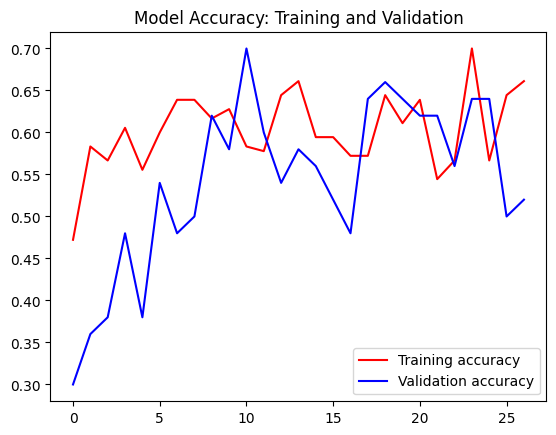

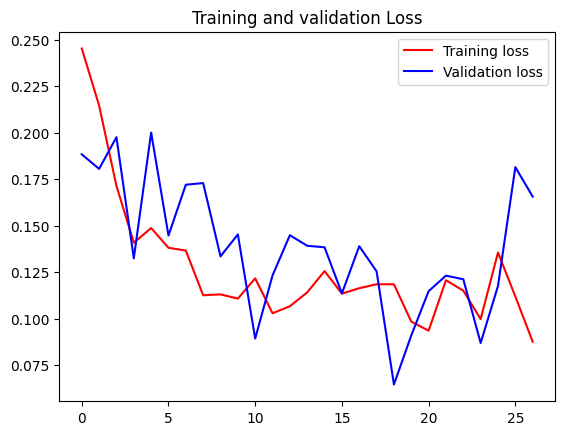

<Figure size 640x480 with 0 Axes>

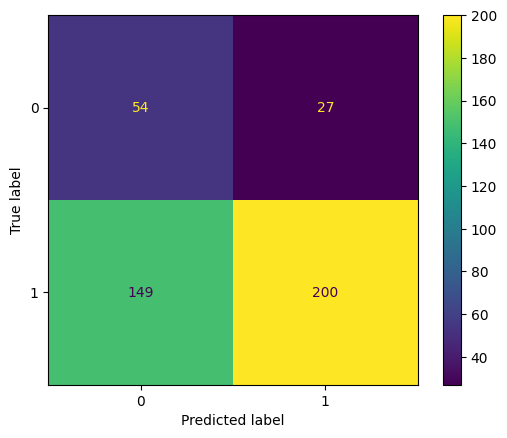


               precision    recall  f1-score   support

           0       0.27      0.67      0.38        81
           1       0.88      0.57      0.69       349

    accuracy                           0.59       430
   macro avg       0.57      0.62      0.54       430
weighted avg       0.77      0.59      0.64       430

Sensitivity: 0.573 Specificity: 0.667 Precision: 0.765 ROC_AUC_SCORE: 0.669



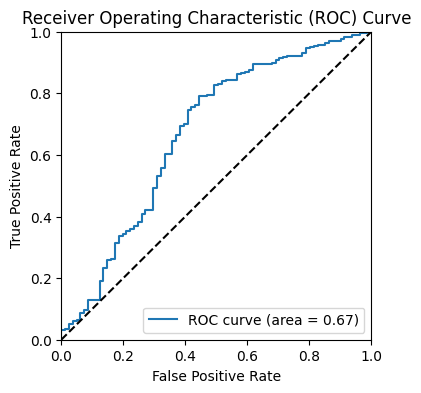

Validation complete...
Traning for Fold: 2
Found 1720 validated image filenames belonging to 2 classes.
Found 430 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 0.1591 - accuracy: 0.5722
Epoch 1: val_accuracy improved from -inf to 0.66000, saving model to /content/drive/MyDrive/msc_project/model/mel_vs_nev&seb_no_aug/model_fold_2.hdf5
18/18 [==============================] - 72s 1s/step - loss: 0.1591 - accuracy: 0.5722 - val_loss: 0.0758 - val_accuracy: 0.6600 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.1027 - accuracy: 0.6111
Epoch 2: val_accuracy did not improve from 0.66000
18/18 [==============================] - 9s 521ms/step - loss: 0.1027 - accuracy: 0.6111 - val_loss: 0.1320 - val_accuracy: 0.5000 - lr: 2.0000e-05

Epoch 3: LearningRateSch

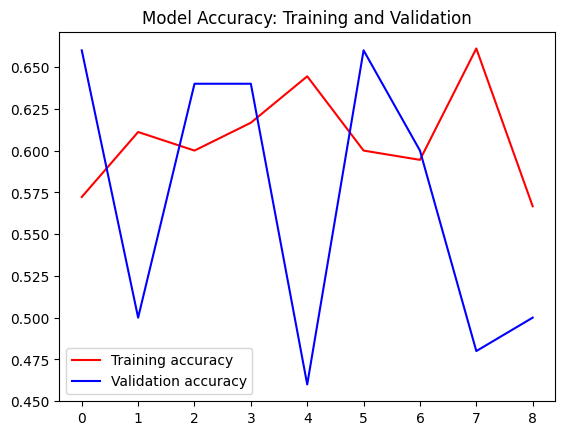

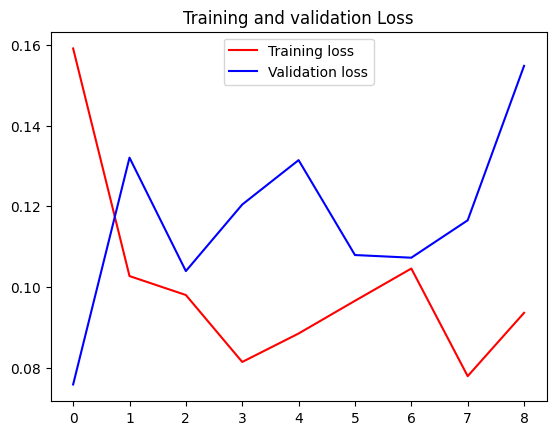

<Figure size 640x480 with 0 Axes>

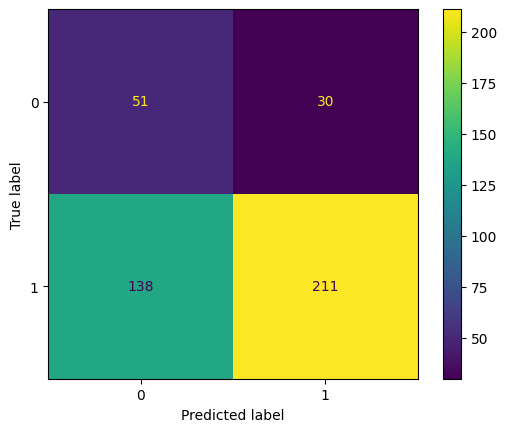


               precision    recall  f1-score   support

           0       0.27      0.63      0.38        81
           1       0.88      0.60      0.72       349

    accuracy                           0.61       430
   macro avg       0.57      0.62      0.55       430
weighted avg       0.76      0.61      0.65       430

Sensitivity: 0.605 Specificity: 0.63 Precision: 0.761 ROC_AUC_SCORE: 0.689



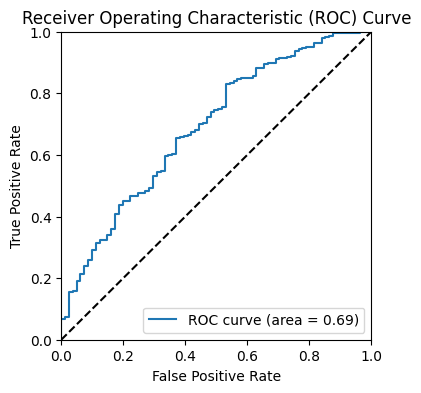

Validation complete...
Traning for Fold: 3
Found 1720 validated image filenames belonging to 2 classes.
Found 430 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 0.1283 - accuracy: 0.5667
Epoch 1: val_accuracy improved from -inf to 0.72000, saving model to /content/drive/MyDrive/msc_project/model/mel_vs_nev&seb_no_aug/model_fold_3.hdf5
18/18 [==============================] - 67s 853ms/step - loss: 0.1283 - accuracy: 0.5667 - val_loss: 0.0601 - val_accuracy: 0.7200 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.1157 - accuracy: 0.5944
Epoch 2: val_accuracy improved from 0.72000 to 0.86000, saving model to /content/drive/MyDrive/msc_project/model/mel_vs_nev&seb_no_aug/model_fold_3.hdf5
18/18 [==============================] - 11s 628ms/step - loss: 0.11

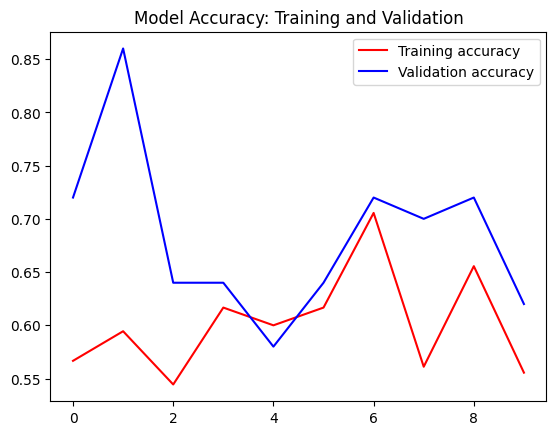

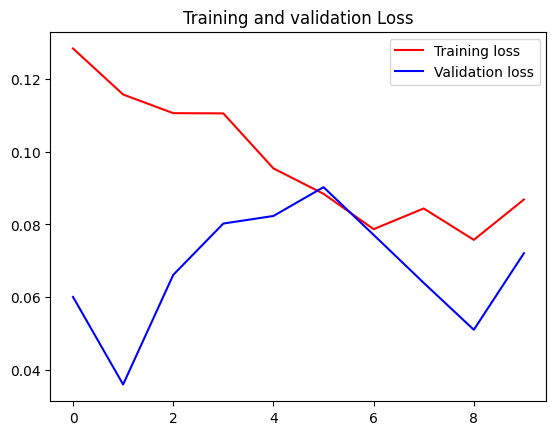

<Figure size 640x480 with 0 Axes>

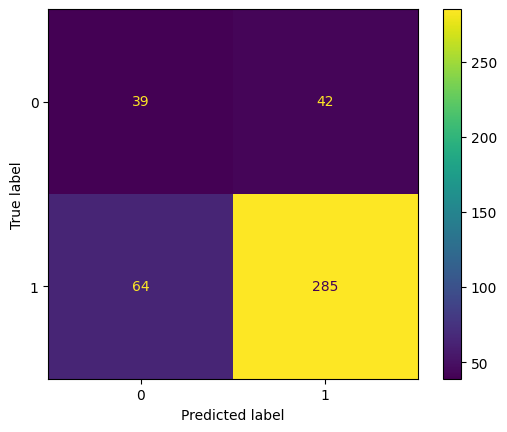


               precision    recall  f1-score   support

           0       0.38      0.48      0.42        81
           1       0.87      0.82      0.84       349

    accuracy                           0.75       430
   macro avg       0.63      0.65      0.63       430
weighted avg       0.78      0.75      0.76       430

Sensitivity: 0.817 Specificity: 0.481 Precision: 0.779 ROC_AUC_SCORE: 0.68



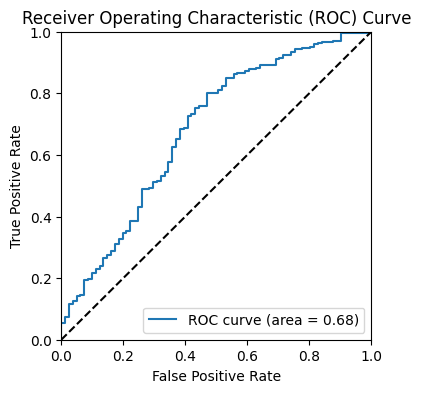

Validation complete...
Traning for Fold: 4
Found 1720 validated image filenames belonging to 2 classes.
Found 430 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 0.1088 - accuracy: 0.5278
Epoch 1: val_accuracy improved from -inf to 0.60000, saving model to /content/drive/MyDrive/msc_project/model/mel_vs_nev&seb_no_aug/model_fold_4.hdf5
18/18 [==============================] - 65s 752ms/step - loss: 0.1088 - accuracy: 0.5278 - val_loss: 0.0923 - val_accuracy: 0.6000 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.1102 - accuracy: 0.5944
Epoch 2: val_accuracy improved from 0.60000 to 0.66000, saving model to /content/drive/MyDrive/msc_project/model/mel_vs_nev&seb_no_aug/model_fold_4.hdf5
18/18 [==============================] - 10s 580ms/step - loss: 0.11

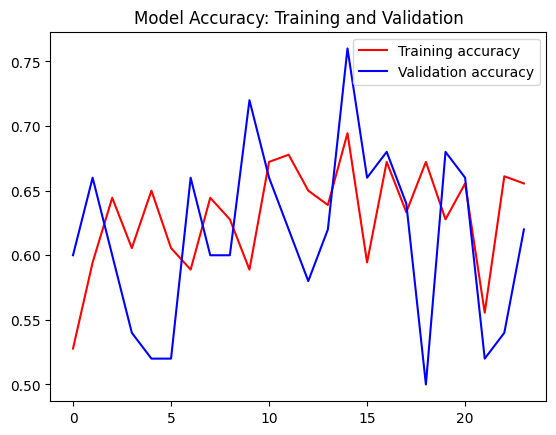

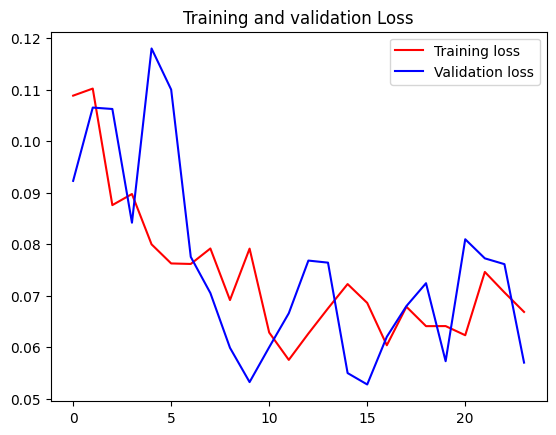

<Figure size 640x480 with 0 Axes>

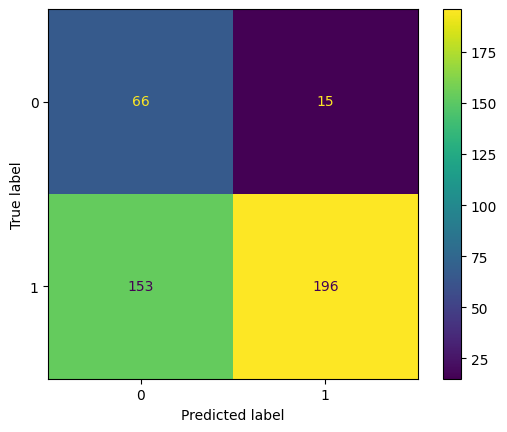


               precision    recall  f1-score   support

           0       0.30      0.81      0.44        81
           1       0.93      0.56      0.70       349

    accuracy                           0.61       430
   macro avg       0.62      0.69      0.57       430
weighted avg       0.81      0.61      0.65       430

Sensitivity: 0.562 Specificity: 0.815 Precision: 0.811 ROC_AUC_SCORE: 0.756



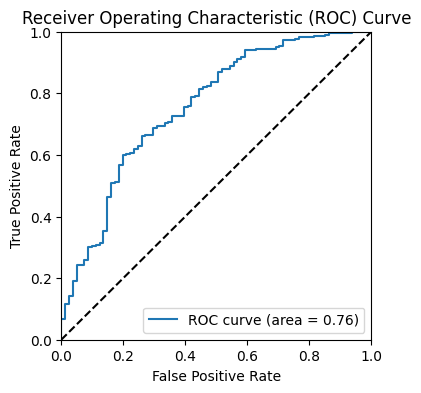

Validation complete...
Traning for Fold: 5
Found 1720 validated image filenames belonging to 2 classes.
Found 430 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 0.0636 - accuracy: 0.6500
Epoch 1: val_accuracy improved from -inf to 0.42000, saving model to /content/drive/MyDrive/msc_project/model/mel_vs_nev&seb_no_aug/model_fold_5.hdf5
18/18 [==============================] - 67s 775ms/step - loss: 0.0636 - accuracy: 0.6500 - val_loss: 0.1173 - val_accuracy: 0.4200 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.0725 - accuracy: 0.6167
Epoch 2: val_accuracy improved from 0.42000 to 0.64000, saving model to /content/drive/MyDrive/msc_project/model/mel_vs_nev&seb_no_aug/model_fold_5.hdf5
18/18 [==============================] - 10s 585ms/step - loss: 0.07

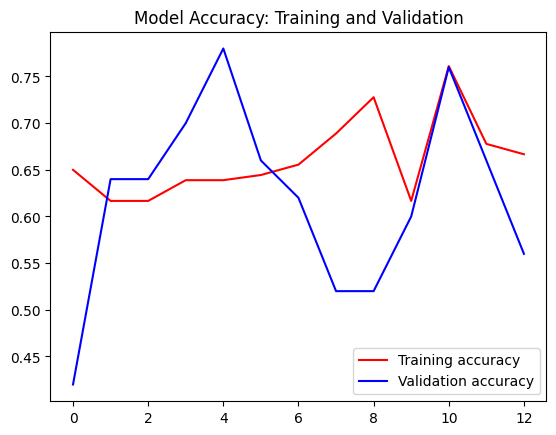

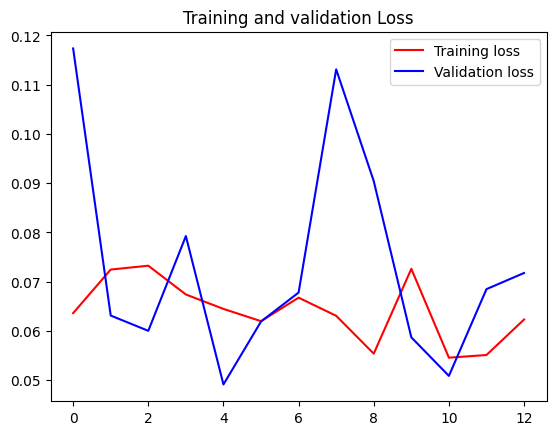

<Figure size 640x480 with 0 Axes>

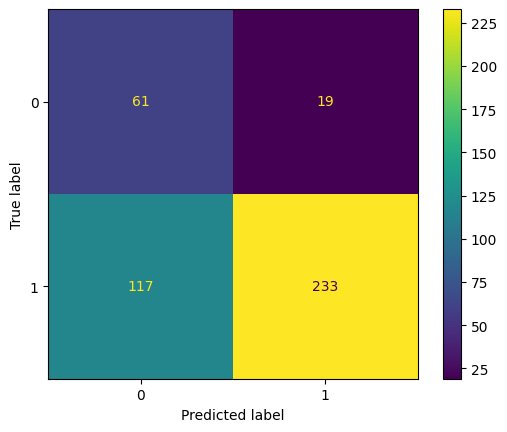


               precision    recall  f1-score   support

           0       0.34      0.76      0.47        80
           1       0.92      0.67      0.77       350

    accuracy                           0.68       430
   macro avg       0.63      0.71      0.62       430
weighted avg       0.82      0.68      0.72       430

Sensitivity: 0.666 Specificity: 0.762 Precision: 0.816 ROC_AUC_SCORE: 0.786



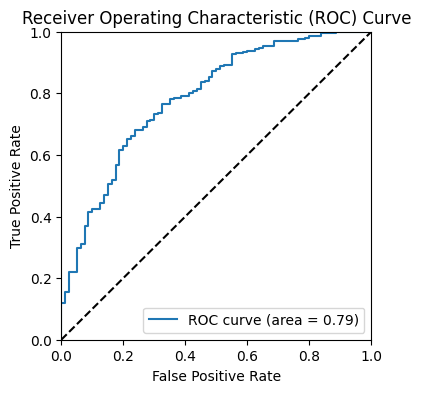

Validation complete...


In [17]:
# Perform k-fold cross-validation
fold = 1
for i, (train_index, val_index) in enumerate(skf.split(train_paths, train_labels)):
    print(f"Traning for Fold: {fold}")
    # Split the data into train and validation sets for this fold
    train_paths_fold, val_paths_fold = train_paths[train_index], train_paths[val_index]
    train_labels_fold, val_labels_fold = train_labels[train_index], train_labels[val_index]

    # Create data generators for this fold
    train_generator_fold = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': train_paths_fold, 'class': train_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=batch
    )

    val_generator_fold = datagen.flow_from_dataframe(
      pd.DataFrame({'filename': val_paths_fold, 'class': val_labels_fold}),
      directory=train_dir,
      x_col='filename',
      y_col='class',
      target_size=image_size,
      batch_size=batch
  )


    train_steps = np.ceil(len(train_generator_fold) / batch)
    val_steps = np.ceil(len(val_generator_fold) / batch)

    #set path to save model
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = model_path + f'/model_fold_{fold}.hdf5',
                                                  monitor = 'val_accuracy',
                                                  verbose = 1,
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

    callbacks = [early_stopping, checkpointer, lr_scheduler]


    # Compile the model
    model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])

    # Train the model on the training data and evaluate on the validation data
    history = model.fit(
        train_generator_fold,
        steps_per_epoch=train_steps,
        validation_data=val_generator_fold,
        validation_steps=val_steps,
        epochs=30,
        callbacks=callbacks)

    graph_it(history)


    val_generator_fold_test = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': val_paths_fold, 'class': val_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )

    print(f"\nValidating for fold {fold}... \n")
    print("Loading model...")

    model.load_weights(filepath = model_path + f'/model_fold_{fold}.hdf5')
    test_it(model, val_generator_fold_test)

    print("Validation complete...")

    fold += 1


**Model Evaluation using test data**

In [18]:
test_dir

'/content/drive/MyDrive/msc_project/test/task1'

In [19]:
test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )
test_generator.shuffle = False

Found 600 images belonging to 2 classes.


Test using model 1
600/600 [==============================] - 148s 247ms/step


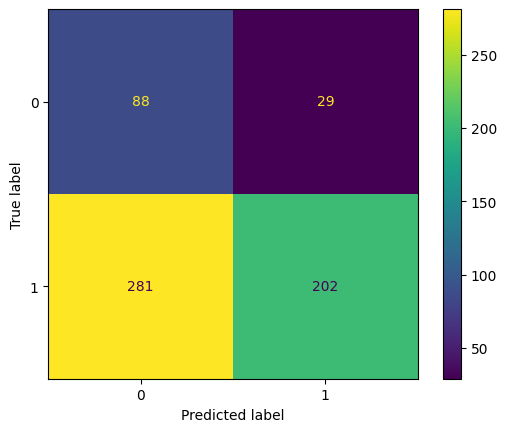


               precision    recall  f1-score   support

           0       0.24      0.75      0.36       117
           1       0.87      0.42      0.57       483

    accuracy                           0.48       600
   macro avg       0.56      0.59      0.46       600
weighted avg       0.75      0.48      0.53       600

Sensitivity: 0.418 Specificity: 0.752 Precision: 0.75 ROC_AUC_SCORE: 0.613



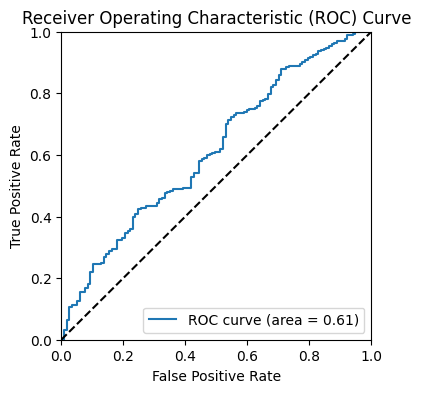

Testing Complete
Test using model 2
600/600 [==============================] - 25s 42ms/step


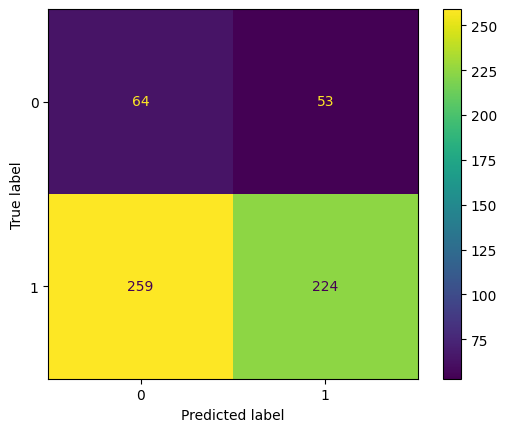


               precision    recall  f1-score   support

           0       0.20      0.55      0.29       117
           1       0.81      0.46      0.59       483

    accuracy                           0.48       600
   macro avg       0.50      0.51      0.44       600
weighted avg       0.69      0.48      0.53       600

Sensitivity: 0.464 Specificity: 0.547 Precision: 0.69 ROC_AUC_SCORE: 0.544



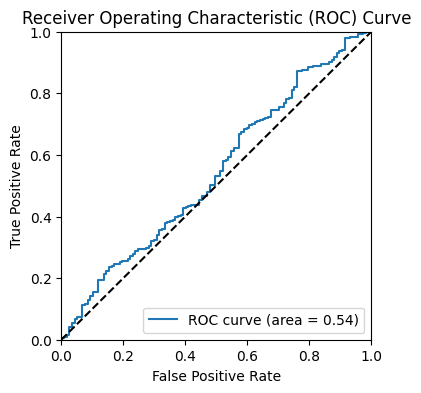

Testing Complete
Test using model 3
600/600 [==============================] - 26s 43ms/step


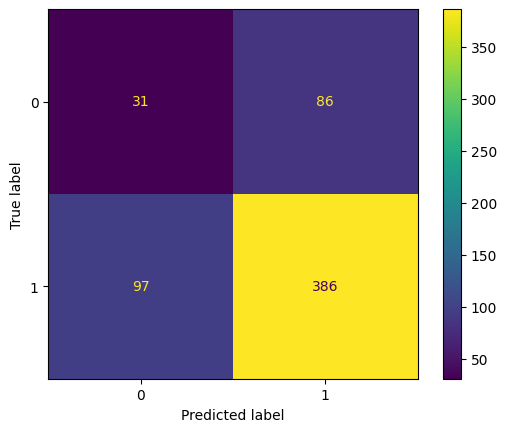


               precision    recall  f1-score   support

           0       0.24      0.26      0.25       117
           1       0.82      0.80      0.81       483

    accuracy                           0.69       600
   macro avg       0.53      0.53      0.53       600
weighted avg       0.71      0.69      0.70       600

Sensitivity: 0.799 Specificity: 0.265 Precision: 0.706 ROC_AUC_SCORE: 0.57



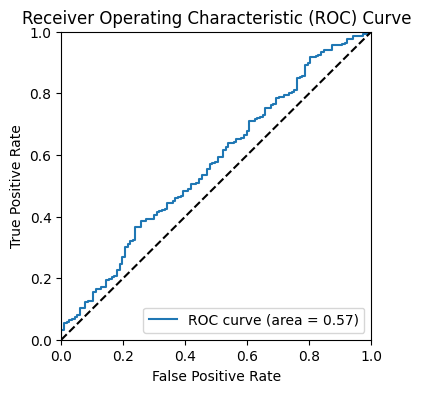

Testing Complete
Test using model 4
600/600 [==============================] - 27s 46ms/step


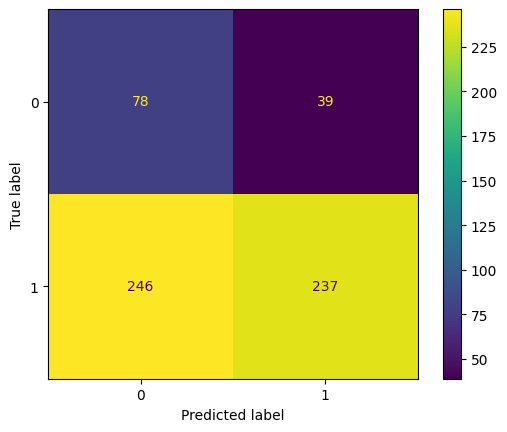


               precision    recall  f1-score   support

           0       0.24      0.67      0.35       117
           1       0.86      0.49      0.62       483

    accuracy                           0.53       600
   macro avg       0.55      0.58      0.49       600
weighted avg       0.74      0.53      0.57       600

Sensitivity: 0.491 Specificity: 0.667 Precision: 0.738 ROC_AUC_SCORE: 0.643



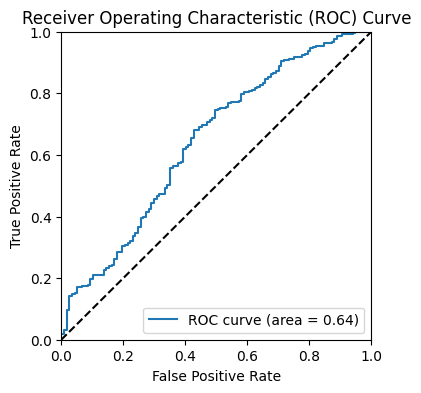

Testing Complete
Test using model 5
600/600 [==============================] - 31s 52ms/step


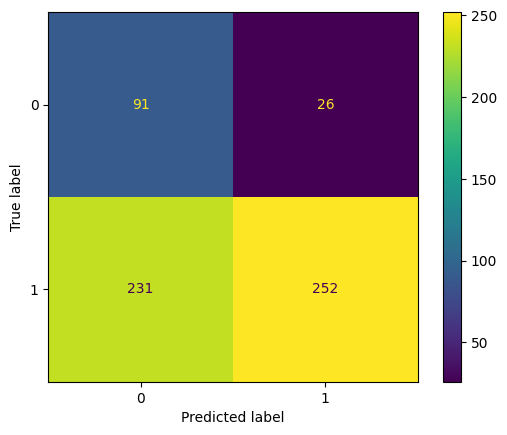


               precision    recall  f1-score   support

           0       0.28      0.78      0.41       117
           1       0.91      0.52      0.66       483

    accuracy                           0.57       600
   macro avg       0.59      0.65      0.54       600
weighted avg       0.78      0.57      0.61       600

Sensitivity: 0.522 Specificity: 0.778 Precision: 0.785 ROC_AUC_SCORE: 0.694



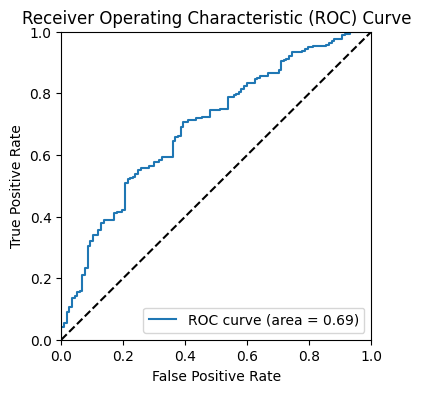

Testing Complete


In [20]:
#set path to best weights from your training please manually! {title}_fold_{fold}
for i in range(1, num_fold + 1):
  print(f"Test using model {i}")
  model.load_weights(filepath = model_path + f'/model_fold_{i}.hdf5')
  test_it(model, test_generator)
  print("Testing Complete")